In [47]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt


In [48]:
# Read both of the tables
df_1 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
df_2 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))
# df_1 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(0,9))
# df_2 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv', skiprows=6, delimiter='\t', usecols=range(9,18))

In [49]:
# Merge the dataframes
df_m = pd.merge(df_1, df_2.rename(columns={'time.1':'time'}), on='time',  how='left')

# Interpolate missing values (since we merged on different sized tables
df_m.set_index('time', inplace=True)
#df_m.interpolate(method='index', inplace=True)
df_m.bfill(inplace=True)
df_m.reset_index(inplace=True)

# Constrain time to range we care about observing

# Cato 2022 Times
tstart = 1450
tend = 1500.5
imu_direction = -1

# Spring2023 Airbrakes
# tstart = 1510
# tend = 1640.5
# imu_direction = 1

df_m = df_m[(df_m['time'] < tend) & (df_m['time'] > tstart)]

# Visually check that things look like
print(df_m.head())

              time   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
62298  1450.000977  0.118013  0.045976 -9.785261 -0.480377  0.419746   
62299  1450.001953  0.111720  0.076803 -9.747754 -0.743052  0.197038   
62300  1450.003052  0.091082  0.129472 -9.762688 -0.816527  0.232145   
62301  1450.004028  0.090294  0.173115 -9.784898 -0.853695  0.216455   
62302  1450.005005  0.096537  0.210535 -9.791042 -0.835746  0.396840   

         gyro_z  gps  gps.1   altitude  estLinearAccelX  estLinearAccelY  \
62298  0.298899  0.0    4.0  35.718876        -0.297267        -0.124500   
62299  0.486555  0.0    4.0  35.718876        -0.297267        -0.124500   
62300  0.363688  0.0    4.0  35.718876        -0.318604        -0.048872   
62301  0.287782  0.0    4.0  35.718876        -0.318604        -0.048872   
62302  0.254113  0.0    4.0  35.718876        -0.343310         0.049632   

       estLinearAccelZ      roll     pitch       yaw  gps.2  
62298        -0.044540 -0.013491  0.043674  1.47

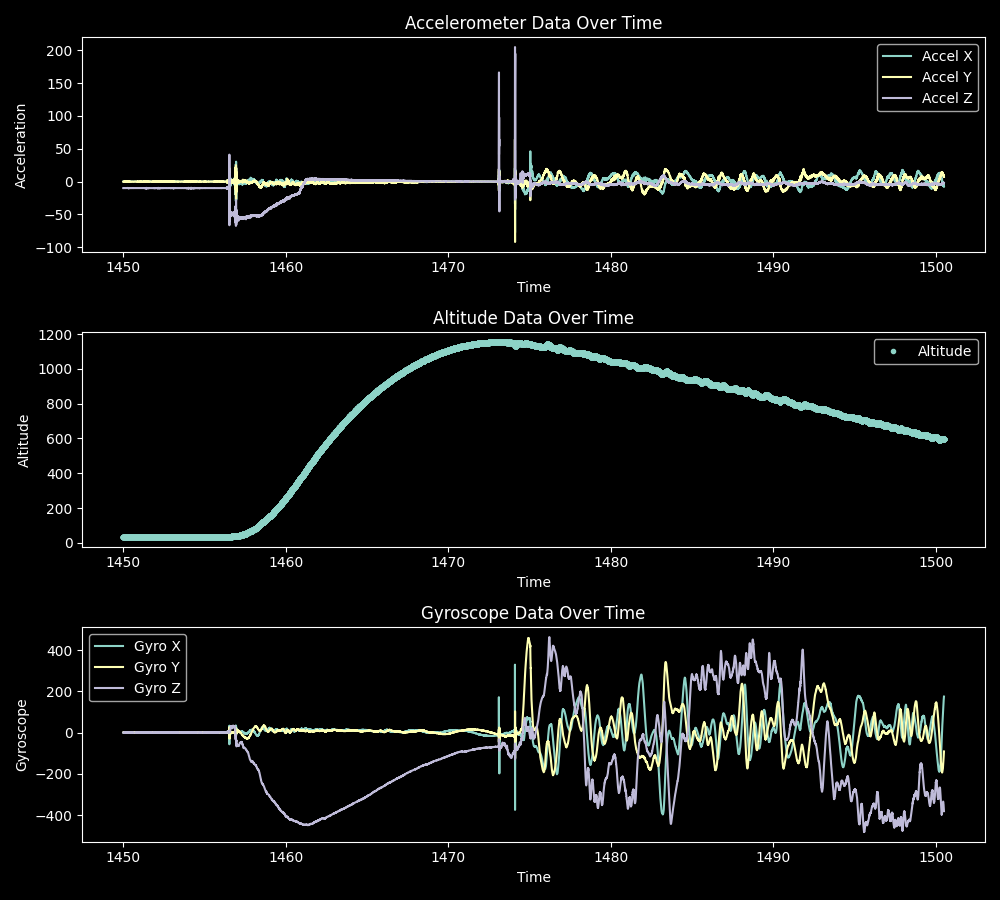

In [50]:
# Plot accelerometer data
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)
plt.plot(df_m['time'], df_m['accel_x'], label='Accel X')
plt.plot(df_m['time'], df_m['accel_y'], label='Accel Y')
plt.plot(df_m['time'], df_m['accel_z'], label='Accel Z')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Accelerometer Data Over Time')

# Plot Altitude data
plt.subplot(3, 1, 2)
plt.plot(df_m['time'], df_m['altitude'], '.', label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

# Plot gyroscope data
plt.subplot(3, 1, 3)
plt.plot(df_m['time'], df_m['gyro_x'], label='Gyro X')
plt.plot(df_m['time'], df_m['gyro_y'], label='Gyro Y')
plt.plot(df_m['time'], df_m['gyro_z'], label='Gyro Z')
plt.xlabel('Time')
plt.ylabel('Gyroscope')
plt.legend()
plt.title('Gyroscope Data Over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [51]:
import filterpy.kalman as kf
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from scipy.signal import butter, lfilter, freqz
import scipy
import mathutils
import math
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



In [52]:
time_series = df_m['time']
altitude_series = df_m['altitude']
accel_x_ser = df_m["estLinearAccelX"]
accel_y_ser = df_m["estLinearAccelY"]
accel_z_ser = df_m["estLinearAccelZ"]
gyro_x_ser = df_m["gyro_x"]
gyro_y_ser = df_m["gyro_y"]
gyro_z_ser = df_m["gyro_z"]

In [53]:

gravity_accel = -9.81 # m/s per second

rho = 1.2

def clamp(value, minVal, maxVal):
    return max(min(value,maxVal), minVal)

def getRegressionEstimate(time, altitude, apogee_estimate_max):
    quad_model = np.poly1d(np.polyfit(time, altitude, 2))

    a, b, c = quad_model.coef
    if (a >= 0):
        return apogee_estimate_max
    
    vertex_x = (-b) / (2 * a)
    
    return clamp(quad_model(vertex_x), 0, apogee_estimate_max)

def getApogeeEstimate(current_alt, current_velocity, Cd, area, mass, accel_multiplier):
    # trajectory formula
    # a(x**2) + bx + c
    # (0.5 * (gravity_accel + drag_accel))(x**2) + (velo)x + (current_alt)
    # where x is time
    
    vmag = abs(current_velocity)
    drag_force = -0.5 * rho * vmag * current_velocity * Cd * area
    
    gravity_force = gravity_accel * mass
    
    # drag_accel = drag_force / mass

    # a = (0.5 * ((gravity_accel + drag_accel) * accel_multiplier))
    total_accel = (gravity_force + drag_force) / mass
    
    a = (total_accel * accel_multiplier) * 0.5
    b = current_velocity
    c = current_alt
    
    # get vertex X (-b/2a)
    vertex_x = (-b) / (2 * a)
    
    # return the y-value at that location
    return (a * (vertex_x**2)) + (b * vertex_x) + c

In [54]:
altitude_data = altitude_series.to_numpy()
time_data = time_series.to_numpy()

accel_x = accel_x_ser.to_numpy()
accel_y = accel_y_ser.to_numpy()
accel_z = accel_z_ser.to_numpy()

gyro_x = gyro_x_ser.to_numpy()
gyro_y = gyro_y_ser.to_numpy()
gyro_z = gyro_z_ser.to_numpy()


def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

R, Q = 0.02, 0.09#0.08
accelR, accelQ = 0.02, 0.10

tracker = FirstOrderKF(R, Q, dt=1)
accel_kf = FirstOrderKF(accelR, accelQ, dt=1)

accel_kf.alpha = 1.01#1.0005
tracker.alpha = 1.0010#1.0005

current_time_index = 0
dt = 1

time_values = []
pos_estimates = []
vel_estimates = []

apogee_estimates = []

accel_actual_values = []
accel_estimates = []
jerk_estimates = []

orient_diff_vals = []
up_orientation = mathutils.Euler([0,0,1]).to_quaternion()


# Parameters for quadratic model
quad_mass = 20 #25     #kg
quad_area = 0.018#0.15    #m
quad_Cd = 0.23#0.023       #drag coefficient
quad_accel_multiplier = 1.22 # Not sure if fudge, need to test with more data

apogee_model_estimates = []

loop_times = []

launch_detected = False
motor_maybe_stopped = False
motor_stopped = False
motor_stop_time = 0

regression_values = []
regression_estimate = 0
accel_deviations = []

averaged_fit_vals = []

accel_alt_estimates = []

altitude_times = []
altitude_corrected = []
previous_alt = 0

alt_dt = 1
accel_dt = 1

for index, value in enumerate(time_data):
    start_time = time.time()
    
    # Append current time value
    time_values.append(value)

    
    if (index > 0):
        accel_dt = value - time_data[index-1]
        
        
    # Get acceleration in global frame
    current_accel = imu_direction * mathutils.Vector((accel_x[index], accel_y[index], accel_z[index]))
    
    current_orientation = mathutils.Euler((math.radians(gyro_x[index]), 
                                           math.radians(gyro_y[index]), 
                                           math.radians(gyro_z[index])))
    current_accel.rotate(current_orientation) 
    accel_actual_values.append(current_accel.z)
    
    # Get deviance from upwards orientation
    current_quat = current_orientation.to_quaternion()
    diff = current_quat.dot(up_orientation)
    orient_diff_vals.append(diff)
    
    # Update acceleration filter
    accel_kf.F = np.array([[1., accel_dt],
                          [0., 1]])    
    accel_kf.Q = Q_discrete_white_noise(2, accel_dt, accelQ)
    accel_kf.predict()
    accel_kf.update(current_accel.z)
    

    # Add acceleration and jerk estimate
    accel_estimates.append(accel_kf.x[0])
    jerk_estimates.append(accel_kf.x[1])

    accel_deviation = np.std(accel_estimates[(index-200):])
    accel_deviations.append(accel_deviation)

    if not motor_stopped:
        if not launch_detected:
            if (abs(accel_kf.x[0]) > 15):
                launch_detected = True
        else:
            if (abs(accel_kf.x[0]) < 15):# and (accel_deviation < 1.5):
                if not motor_maybe_stopped:
                    motor_maybe_stopped = value
                elif (value - motor_maybe_stopped) > 1:
                    motor_stopped = True
                    motor_stop_time = value
                    print(f"motor stopped at {value}")
            else:
                motor_maybe_stopped = False

    if altitude_data[index] != previous_alt:
        if (index > 0):
            alt_dt = value - altitude_times[-1]
            
        previous_alt = altitude_data[index]
        altitude_corrected.append(altitude_data[index])
        altitude_times.append(value)
        
        # Update altitude filter
        alt_noise = Q_discrete_white_noise(2, alt_dt, Q)

        tracker.F = np.array([[1., alt_dt],
                            [0., 1]])
        tracker.Q = alt_noise
        tracker.predict()
        tracker.update(altitude_data[index])
        
        
        # Add time, altitude, velocity estimates
        pos_estimates.append(tracker.x[0])
        vel_estimates.append(tracker.x[1])

        
        # Get quadratic apogee estimate
        current_apogee_est = getApogeeEstimate(tracker.x[0], tracker.x[1],
                                                quad_Cd, quad_area, quad_mass, quad_accel_multiplier)
        
        apogee_estimates.append(current_apogee_est)
        
        # Look at the last few values
        window = 50
        if ((len(altitude_times) > window + 1) and motor_stopped):
            time_in_window = altitude_times[(-window):]
            altitude_in_window = pos_estimates[(-window):]
            
            regression_estimate = getRegressionEstimate(time_in_window, altitude_in_window, current_apogee_est)
            
        else:
            regression_estimate = 0
        

        regression_values.append(regression_estimate)
        
        transition_time = 7.8 # seconds
        
        if not motor_stopped:
            quad_weight = 1.0
            fit_weight = 0.0
        else:
            time_since_stop = value - motor_stop_time
            if time_since_stop > transition_time:
                fit_weight = 1.0
                quad_weight = 0.0
            else:
                fit_weight = time_since_stop / transition_time
                quad_weight = 1.0 - fit_weight
        
        
        averaged_fit = np.average([current_apogee_est, regression_estimate],
                                weights=[quad_weight*2, fit_weight])#(percent_fit * regression_estimate) + (percent_quad * current_apogee_est)
        
        
        averaged_fit_vals.append(averaged_fit)
    

    loop_times.append(time.time() - start_time)

print(np.mean(loop_times))
    
    

motor stopped at 1461.119019
0.00013164266807900465


In [55]:
actual_apogee = np.max(pos_estimates)
print(actual_apogee)

1156.8921601078541


In [56]:
#plt.figure(figsize=(10, 9))

plt.plot(altitude_times, altitude_corrected, '.',label='Altitude Data')
plt.plot(altitude_times, pos_estimates,'.', label='Altitude Estimates')

#lt.plot(altitude_times, vel_estimates, '.', label='Velocity Estimates')

Text(0.5, 1.0, 'Stuff Data Over Time')

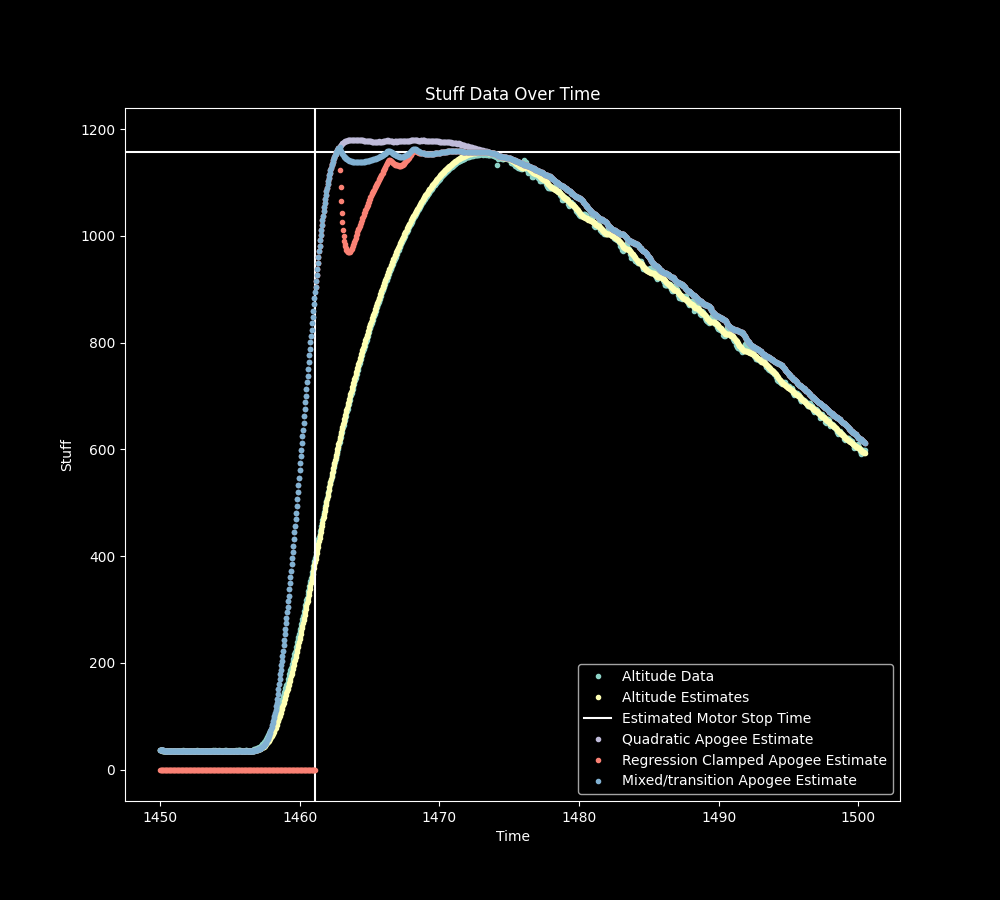

In [57]:

plt.figure(figsize=(10, 9))
#plt.subplot(2, 1, 1)
#plt.plot(time_values, altitude_data, '.', label='Altitude Data')
plt.plot(altitude_times, altitude_corrected, '.',label='Altitude Data')
plt.plot(altitude_times, pos_estimates,'.', label='Altitude Estimates')
plt.axvline(x=motor_stop_time, label='Estimated Motor Stop Time')
plt.axhline(y=actual_apogee)

plt.plot(altitude_times, apogee_estimates, '.',  label='Quadratic Apogee Estimate')
plt.plot(altitude_times, regression_values, '.', label='Regression Clamped Apogee Estimate')
plt.plot(altitude_times, averaged_fit_vals, '.', label='Mixed/transition Apogee Estimate')



plt.xlabel('Time')
plt.ylabel('Stuff')
plt.legend()
plt.title('Stuff Data Over Time')

Text(0.5, 1.0, 'Acceleration Data Over Time')

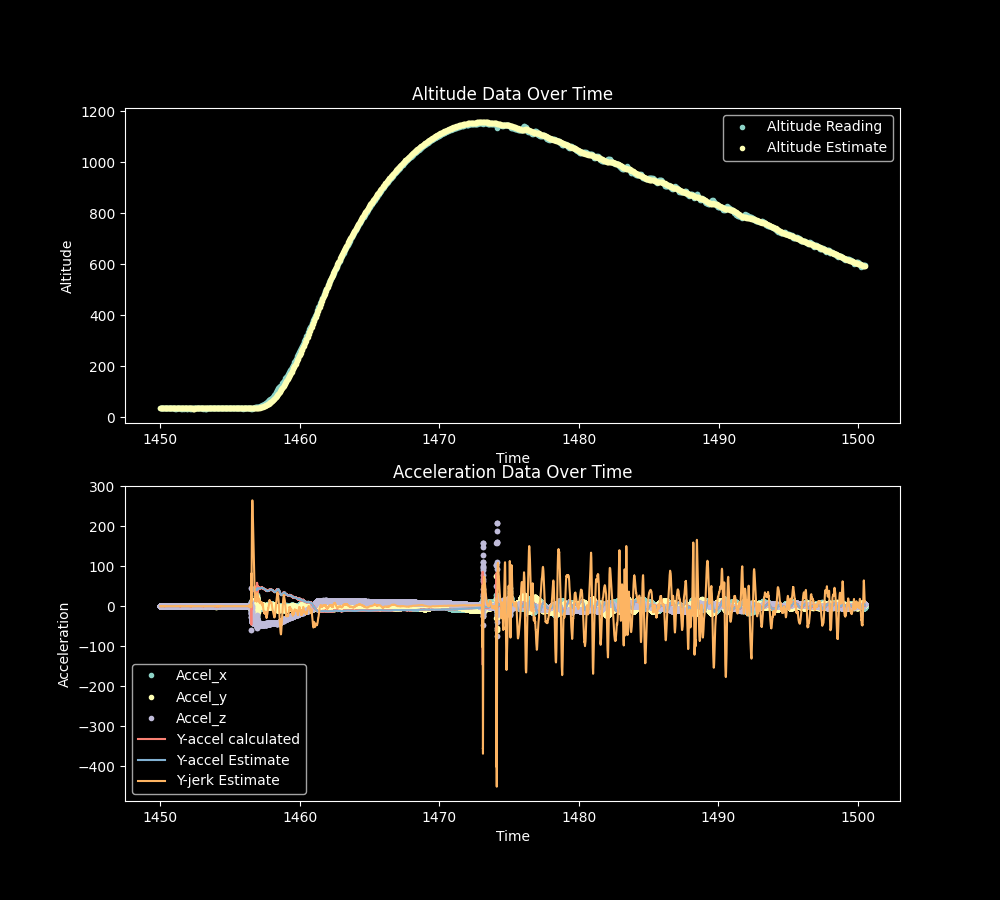

In [58]:
plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.plot(altitude_times, altitude_corrected, '.', label='Altitude Reading')
plt.plot(altitude_times, pos_estimates, '.',  label='Altitude Estimate')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')


plt.subplot(2, 1, 2)

plt.plot(time_values, accel_x, '.', label='Accel_x')
plt.plot(time_values, accel_y, '.', label='Accel_y')
plt.plot(time_values, accel_z, '.', label='Accel_z')
plt.plot(time_values, accel_actual_values, label='Y-accel calculated')
plt.plot(time_values, accel_estimates, label='Y-accel Estimate')
plt.plot(time_values, jerk_estimates, label='Y-jerk Estimate')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Acceleration Data Over Time')


Text(0.5, 1.0, 'Some Data Over Time')

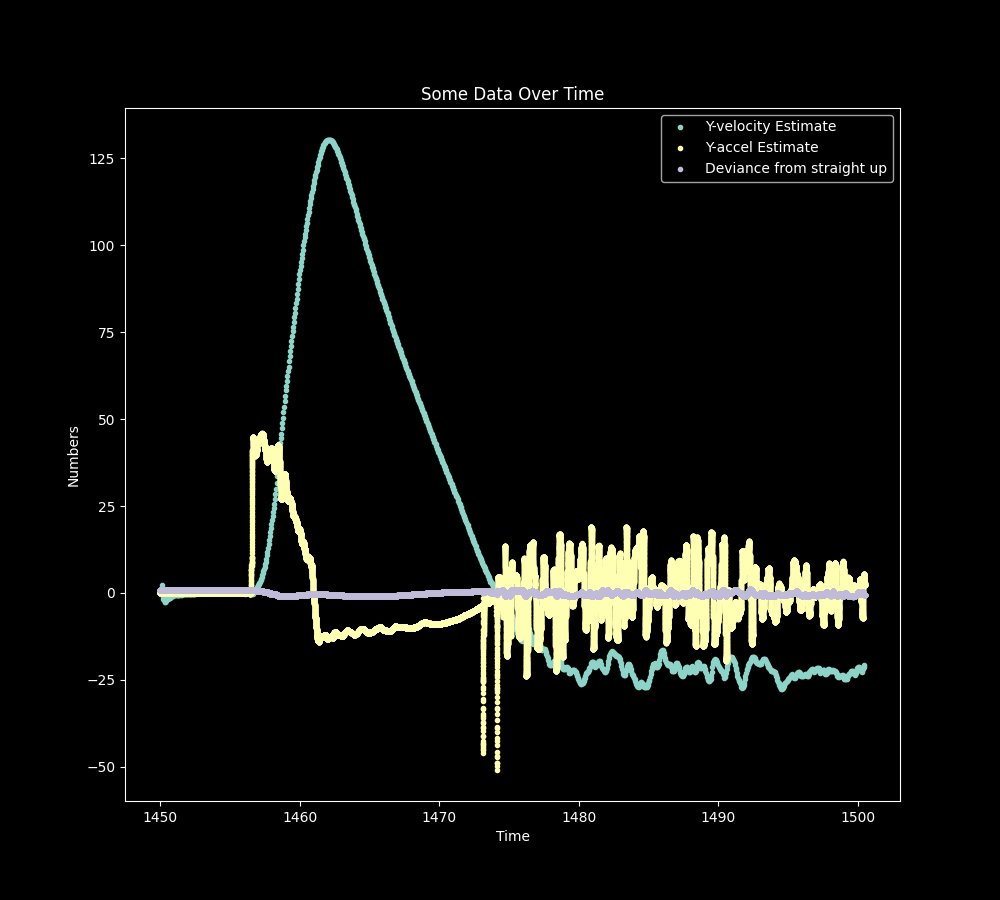

In [59]:
plt.figure(figsize=(10, 9))
plt.plot(altitude_times, vel_estimates, '.', label='Y-velocity Estimate')
plt.plot(time_values, accel_estimates, '.', label='Y-accel Estimate')
plt.plot(time_values, orient_diff_vals, '.', label='Deviance from straight up')

plt.xlabel('Time')
plt.ylabel('Numbers')
plt.legend()
plt.title('Some Data Over Time')